# Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Load Dataset

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"farrelaryansyah","key":"0b197428f83c0f8f9f23d544885fb5bc"}'}

In [3]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d meirnizri/cellphones-recommendations
!unzip -q cellphones-recommendations.zip

Dataset URL: https://www.kaggle.com/datasets/meirnizri/cellphones-recommendations
License(s): ODbL-1.0
  0% 0.00/5.23k [00:00<?, ?B/s]
100% 5.23k/5.23k [00:00<00:00, 17.9MB/s]


In [5]:
# Load dataset
df_phones = pd.read_csv('cellphones data.csv')
df_ratings = pd.read_csv('cellphones ratings.csv')
df_users = pd.read_csv('cellphones users.csv')

# Data Understanding

In [6]:
df_phones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cellphone_id      33 non-null     int64  
 1   brand             33 non-null     object 
 2   model             33 non-null     object 
 3   operating system  33 non-null     object 
 4   internal memory   33 non-null     int64  
 5   RAM               33 non-null     int64  
 6   performance       33 non-null     float64
 7   main camera       33 non-null     int64  
 8   selfie camera     33 non-null     int64  
 9   battery size      33 non-null     int64  
 10  screen size       33 non-null     float64
 11  weight            33 non-null     int64  
 12  price             33 non-null     int64  
 13  release date      33 non-null     object 
dtypes: float64(2), int64(8), object(4)
memory usage: 3.7+ KB


* Total data: 33 baris, 14 kolom
* Tidak ada data yang hilang (semua kolom lengkap)
* Tipe data:

  * Numerik: 10 kolom (8 `int64`, 2 `float64`)
  * Kategorikal: 4 kolom (`object`)


In [7]:
df_phones.head()

,cellphone_id,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date
0,0,Apple,iPhone SE (2022),iOS,128,4,7.23,12,7,2018,4.7,144,429,18/03/2022
1,1,Apple,iPhone 13 Mini,iOS,128,4,7.72,12,12,2438,5.4,141,699,24/09/2021
2,2,Apple,iPhone 13,iOS,128,4,7.75,12,12,3240,6.1,174,699,24/09/2021
3,3,Apple,iPhone 13 Pro,iOS,256,6,7.94,12,12,3065,6.1,204,999,24/09/2021
4,4,Apple,iPhone 13 Pro Max,iOS,256,6,8.01,12,12,4352,6.7,240,1199,24/09/2021


In [8]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   user_id       990 non-null    int64
 1   cellphone_id  990 non-null    int64
 2   rating        990 non-null    int64
dtypes: int64(3)
memory usage: 23.3 KB


* Total data: 990 baris, 3 kolom
* Tidak ada data yang hilang (semua kolom lengkap)
* Tipe data:

  * Numerik: 3 kolom (`int64`)


In [9]:
df_ratings.describe()

,user_id,cellphone_id,rating
count,990.000000,990.000000,990.000000
mean,136.373737,16.421212,6.700000
std,80.664654,9.473466,2.639036
min,0.000000,0.000000,1.000000
25%,74.000000,8.000000,5.000000
50%,128.000000,16.000000,7.000000
75%,226.000000,25.000000,9.000000
max,258.000000,32.000000,18.000000


* Total data: 990 baris
* Rating rata-rata: 6.7
* Rating min–maks: 1 hingga 18
* Rating median: 7
* Sebagian besar rating berada di rentang 5–9
* `user_id`: tersebar dari 0–258
* `cellphone_id`: mencakup 33 ponsel (ID 0–32)

In [10]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     99 non-null     int64 
 1   age         99 non-null     int64 
 2   gender      99 non-null     object
 3   occupation  98 non-null     object
dtypes: int64(2), object(2)
memory usage: 3.2+ KB


* Total data: 99 baris, 4 kolom
* Terdapat 1 nilai hilang pada kolom `occupation`
* Tipe data:

  * Numerik: 2 kolom (`int64`)
  * Kategorikal: 2 kolom (`object`)

In [11]:
df_users.head()

,user_id,age,gender,occupation
0,0,38,Female,Data analyst
1,1,40,Female,team worker in it
2,6,55,Female,IT
3,8,25,Female,Manager
4,10,23,Male,worker


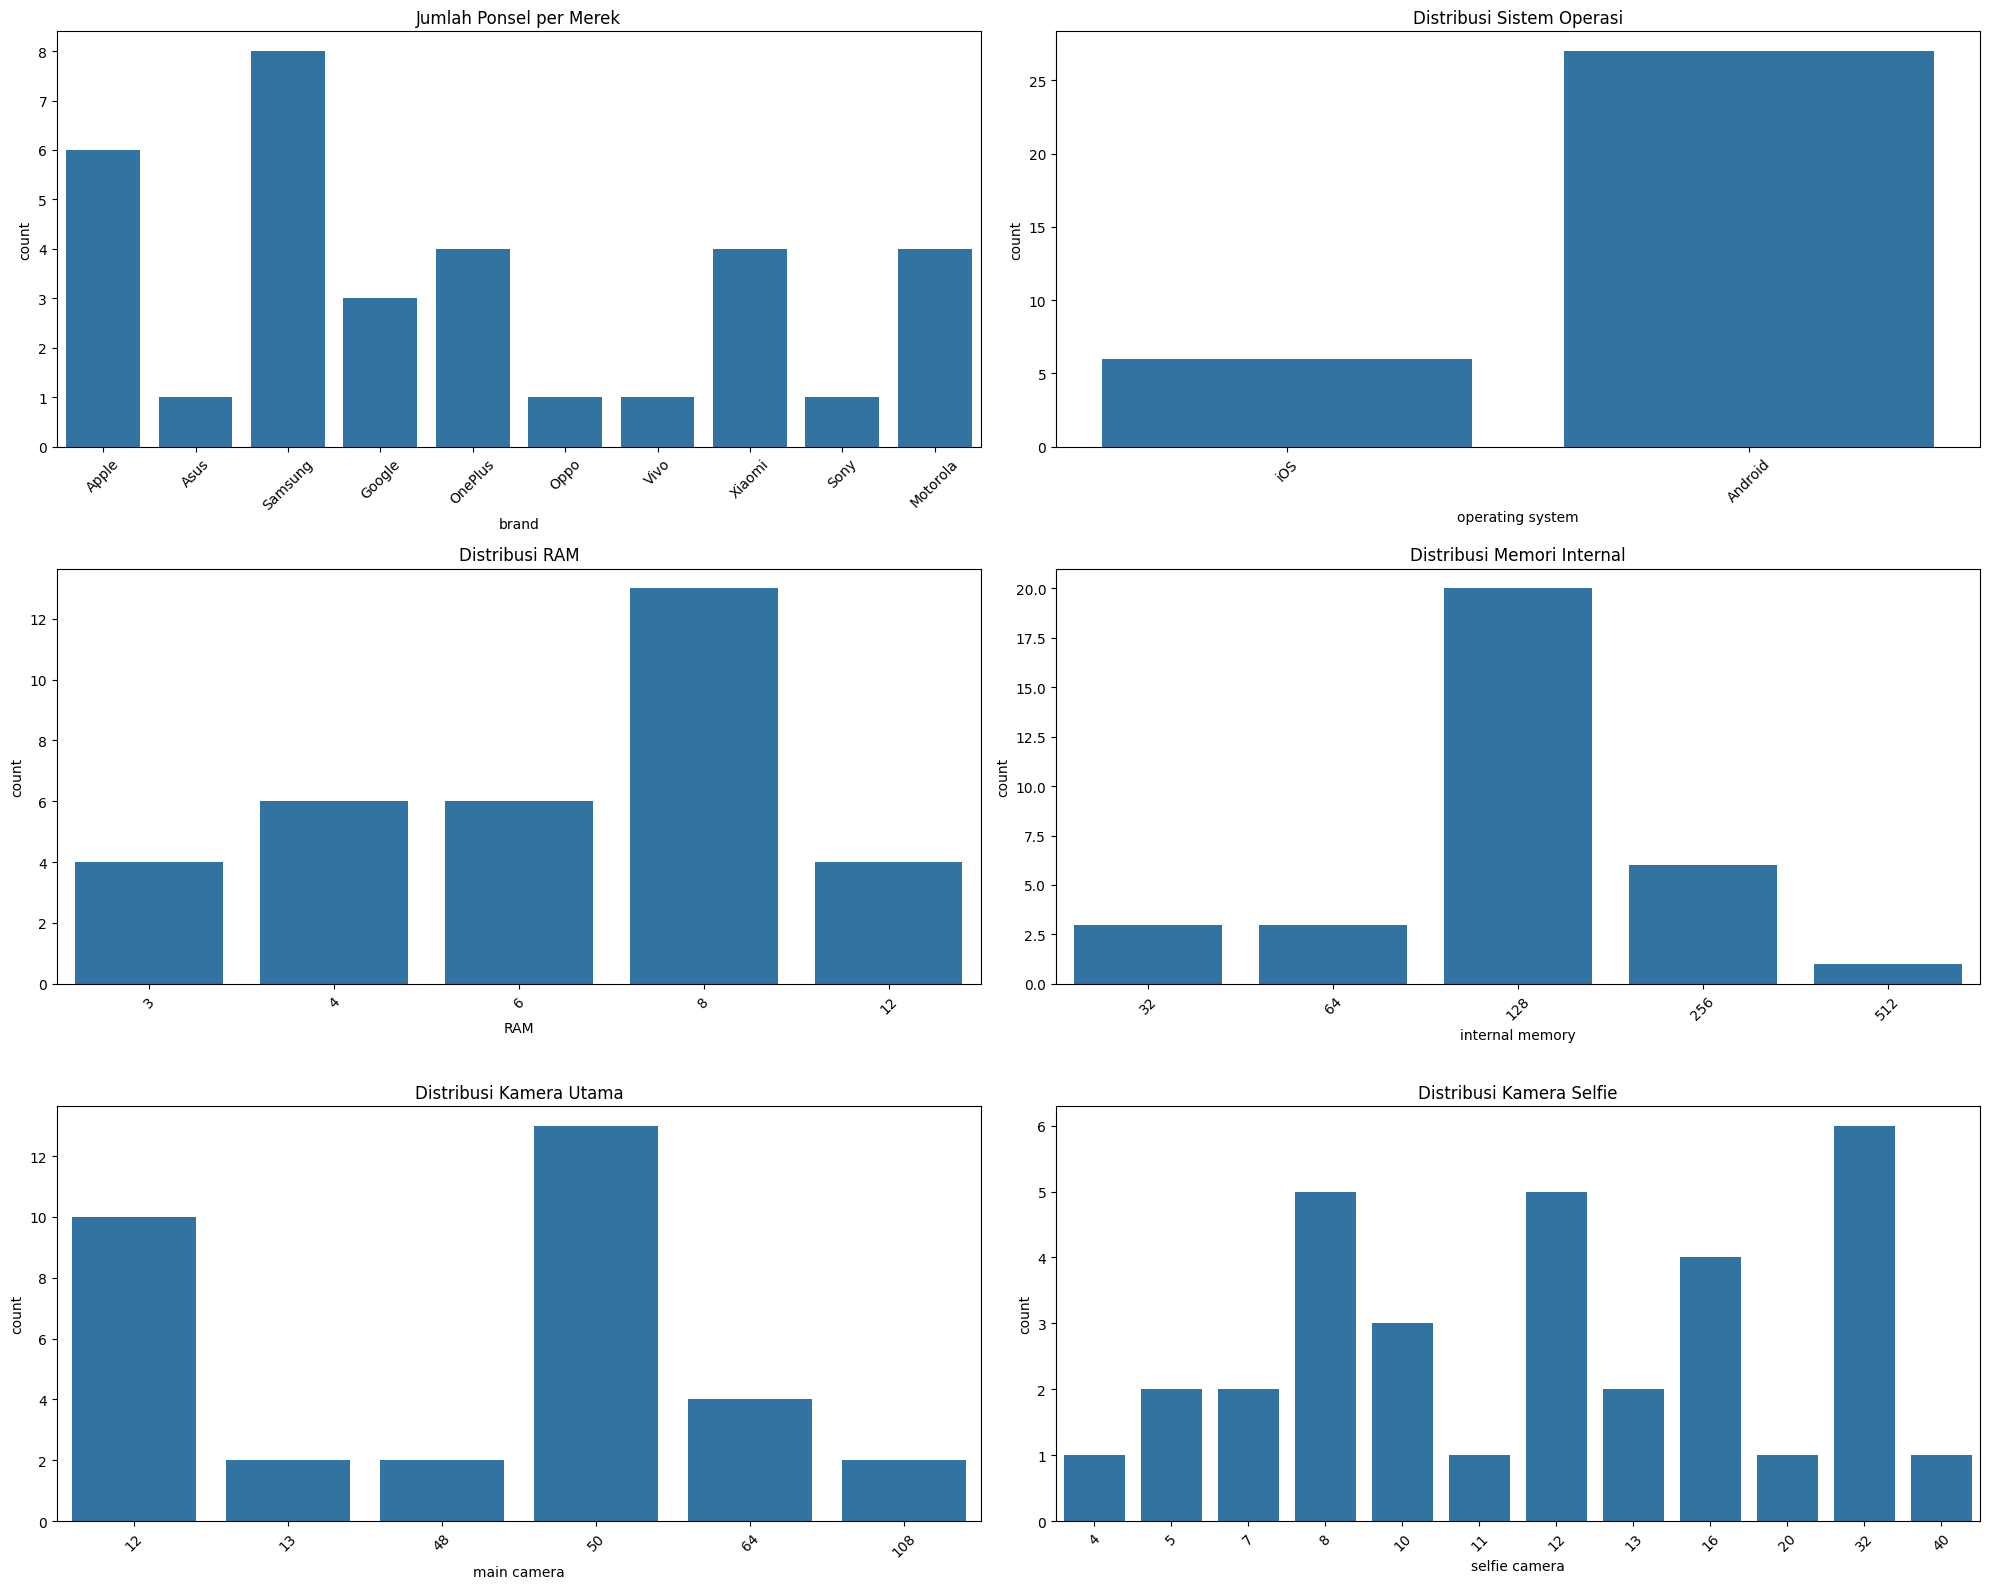

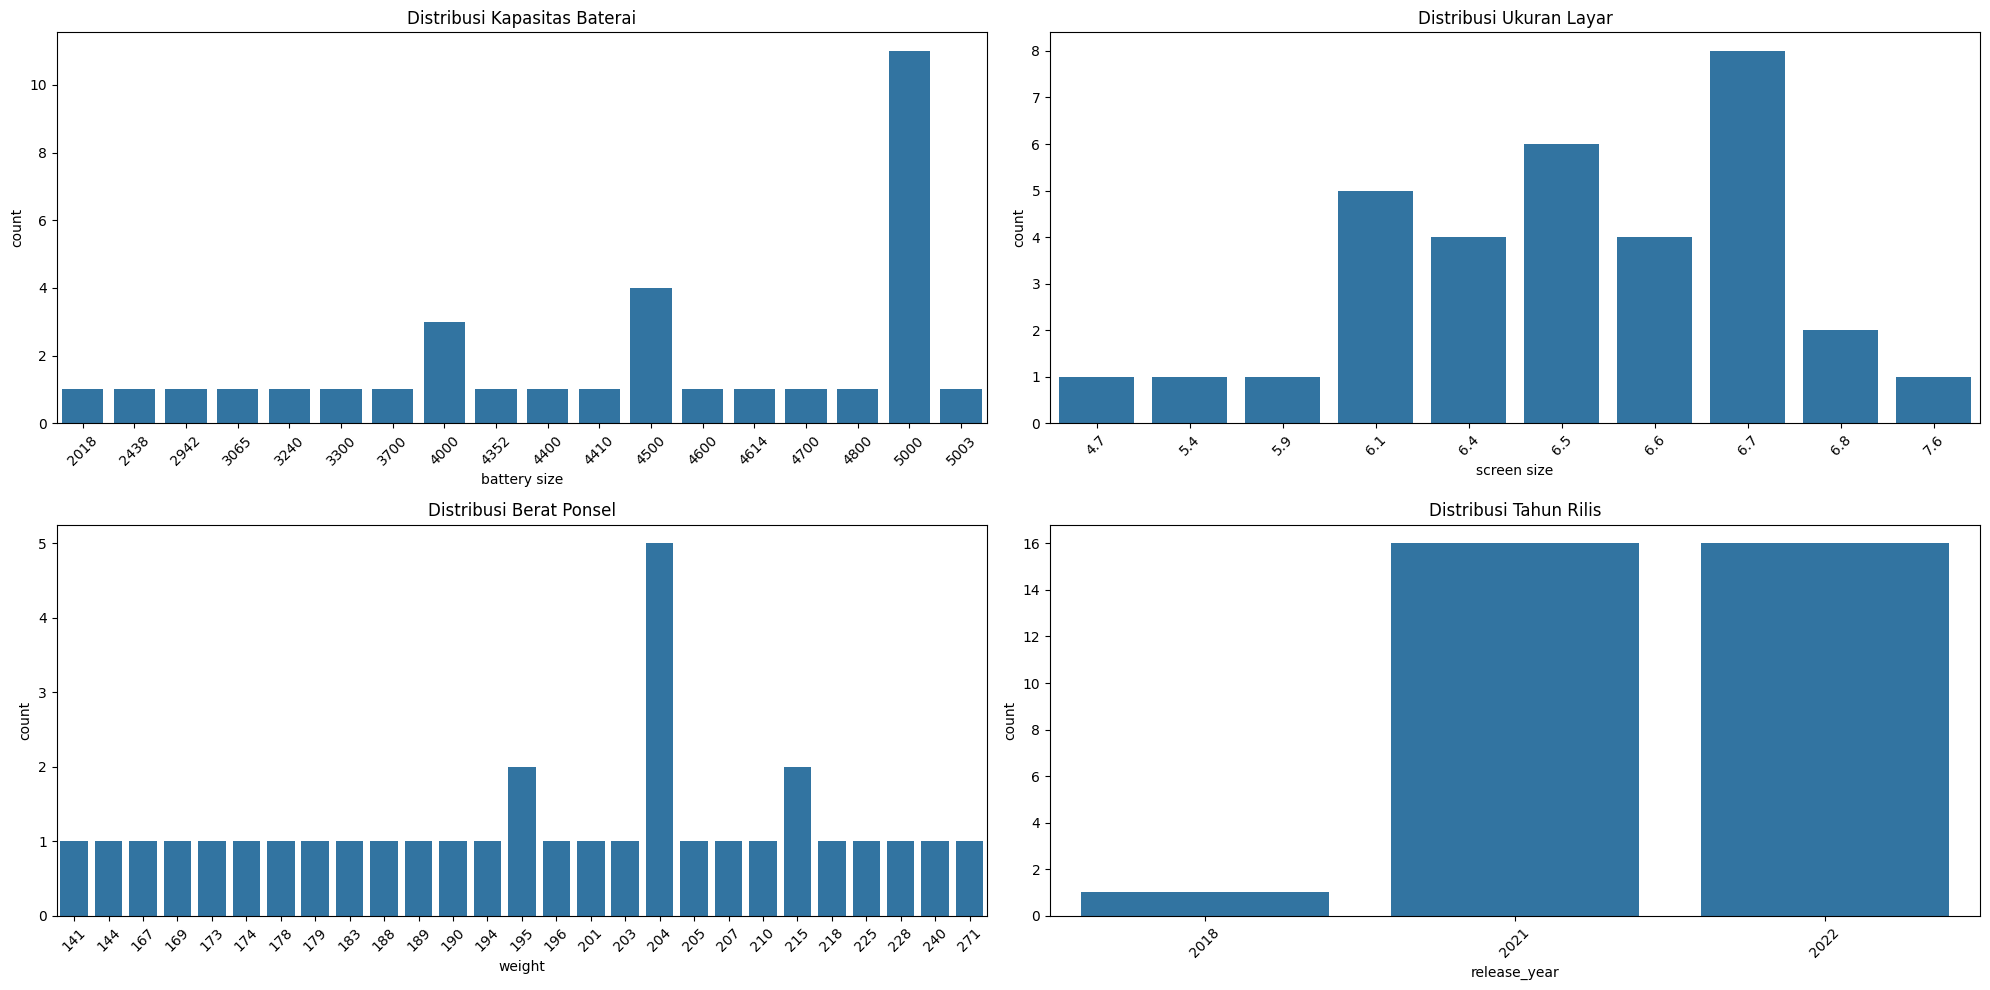

In [12]:
# Release date dalam format datetime
df_phones['release date'] = pd.to_datetime(df_phones['release date'], errors='coerce', dayfirst=True)
df_phones['release_year'] = df_phones['release date'].dt.year

# Frame 1: 6 Visualisasi
plt.figure(figsize=(20, 16))

# 1. Merek
plt.subplot(3, 2, 1)
sns.countplot(data=df_phones, x='brand')
plt.title('Jumlah Ponsel per Merek')
plt.xticks(rotation=45)

# 2. Sistem Operasi
plt.subplot(3, 2, 2)
sns.countplot(data=df_phones, x='operating system')
plt.title('Distribusi Sistem Operasi')
plt.xticks(rotation=45)

# 3. RAM
plt.subplot(3, 2, 3)
sns.countplot(data=df_phones, x='RAM')
plt.title('Distribusi RAM')
plt.xticks(rotation=45)

# 4. Memori Internal
plt.subplot(3, 2, 4)
sns.countplot(data=df_phones, x='internal memory')
plt.title('Distribusi Memori Internal')
plt.xticks(rotation=45)

# 5. Kamera Utama
plt.subplot(3, 2, 5)
sns.countplot(data=df_phones, x='main camera')
plt.title('Distribusi Kamera Utama')
plt.xticks(rotation=45)

# 6. Kamera Selfie
plt.subplot(3, 2, 6)
sns.countplot(data=df_phones, x='selfie camera')
plt.title('Distribusi Kamera Selfie')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Frame 2: 4 Visualisasi
plt.figure(figsize=(20, 10))

# 7. Kapasitas Baterai
plt.subplot(2, 2, 1)
sns.countplot(data=df_phones, x='battery size')
plt.title('Distribusi Kapasitas Baterai')
plt.xticks(rotation=45)

# 8. Ukuran Layar
plt.subplot(2, 2, 2)
sns.countplot(data=df_phones, x='screen size')
plt.title('Distribusi Ukuran Layar')
plt.xticks(rotation=45)

# 9. Berat
plt.subplot(2, 2, 3)
sns.countplot(data=df_phones, x='weight')
plt.title('Distribusi Berat Ponsel')
plt.xticks(rotation=45)

# 10. Tahun Rilis
plt.subplot(2, 2, 4)
sns.countplot(data=df_phones, x='release_year')
plt.title('Distribusi Tahun Rilis')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

* **Jumlah Ponsel per Merek**

  * Samsung mendominasi dengan jumlah ponsel terbanyak.
  * Diikuti oleh Apple dan Xiaomi.
  * Merek dengan jumlah ponsel paling sedikit adalah Asus, Sony, dan Vivo.

* **Sistem Operasi**

  * Mayoritas ponsel menggunakan **Android**.
  * Hanya sebagian kecil yang menggunakan **iOS** (khusus Apple).

* **RAM**

  * Ponsel dengan **RAM 6GB** paling umum ditemukan.
  * Diikuti oleh 4GB dan 8GB.
  * RAM 3GB dan 12GB hanya dimiliki sedikit ponsel.

* **Memori Internal**

  * Kapasitas **128GB** merupakan yang paling banyak digunakan.
  * Diikuti oleh 256GB, sedangkan kapasitas 512GB dan 64GB sangat jarang.

* **Kamera Utama**

  * Kamera 48MP paling banyak ditemukan.
  * Kamera 12MP juga cukup umum.
  * Kamera dengan resolusi sangat tinggi seperti 64MP dan 108MP hanya ada pada beberapa ponsel.

* **Kamera Selfie**

  * Resolusi kamera selfie sangat bervariasi.
  * Resolusi 20MP paling banyak ditemukan, disusul oleh 13MP dan 11MP.
  * Beberapa ponsel memiliki kamera selfie di bawah 10MP, namun jumlahnya lebih sedikit.

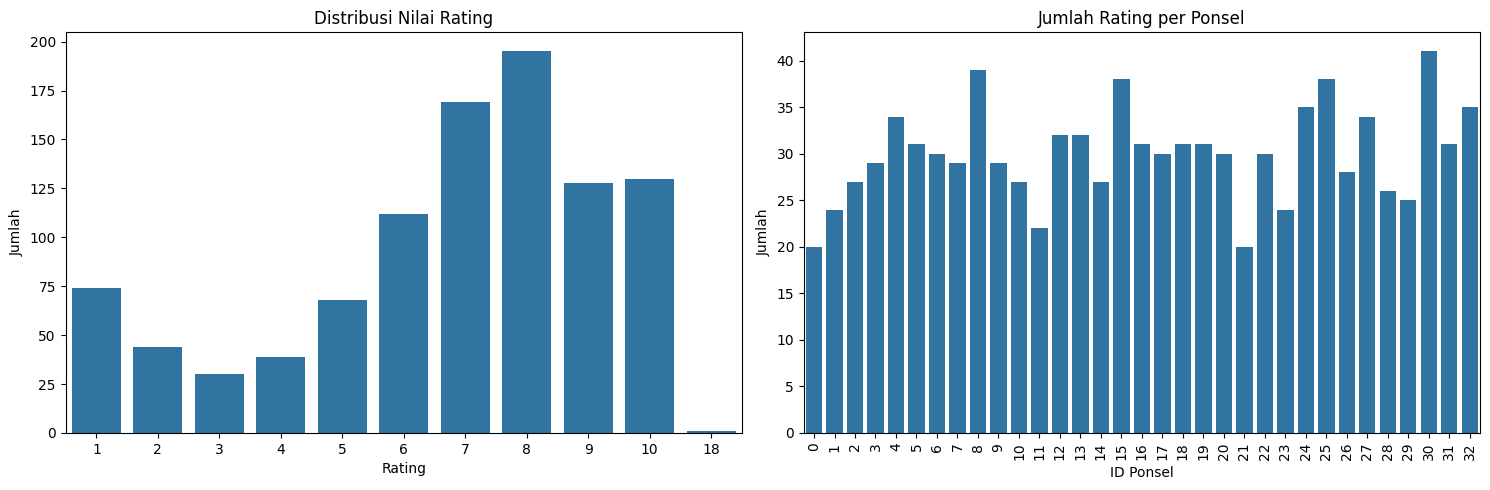

In [13]:
# Visualisasi distribusi rating
plt.figure(figsize=(15, 5))

# 1. Distribusi nilai rating
plt.subplot(1, 2, 1)
sns.countplot(data=df_ratings, x='rating')
plt.title('Distribusi Nilai Rating')
plt.xlabel('Rating')
plt.ylabel('Jumlah')

# 2. Jumlah rating per ponsel (cellphone_id)
plt.subplot(1, 2, 2)
sns.countplot(data=df_ratings, x=df_ratings['cellphone_id'])
plt.title('Jumlah Rating per Ponsel')
plt.xlabel('ID Ponsel')
plt.ylabel('Jumlah')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

* **Distribusi nilai rating**:

  * Rating paling umum: 8, diikuti oleh 7, 9, dan 10.
  * Sebagian besar pengguna memberi rating antara 6–10.
  * Terdapat outlier pada rating 18 (kemungkinan data salah input).

* **Jumlah rating per ponsel**:

  * Setiap ponsel mendapat jumlah rating yang cukup merata (sekitar 20–42 rating).
  * Ponsel dengan ID 30 memiliki jumlah rating terbanyak.

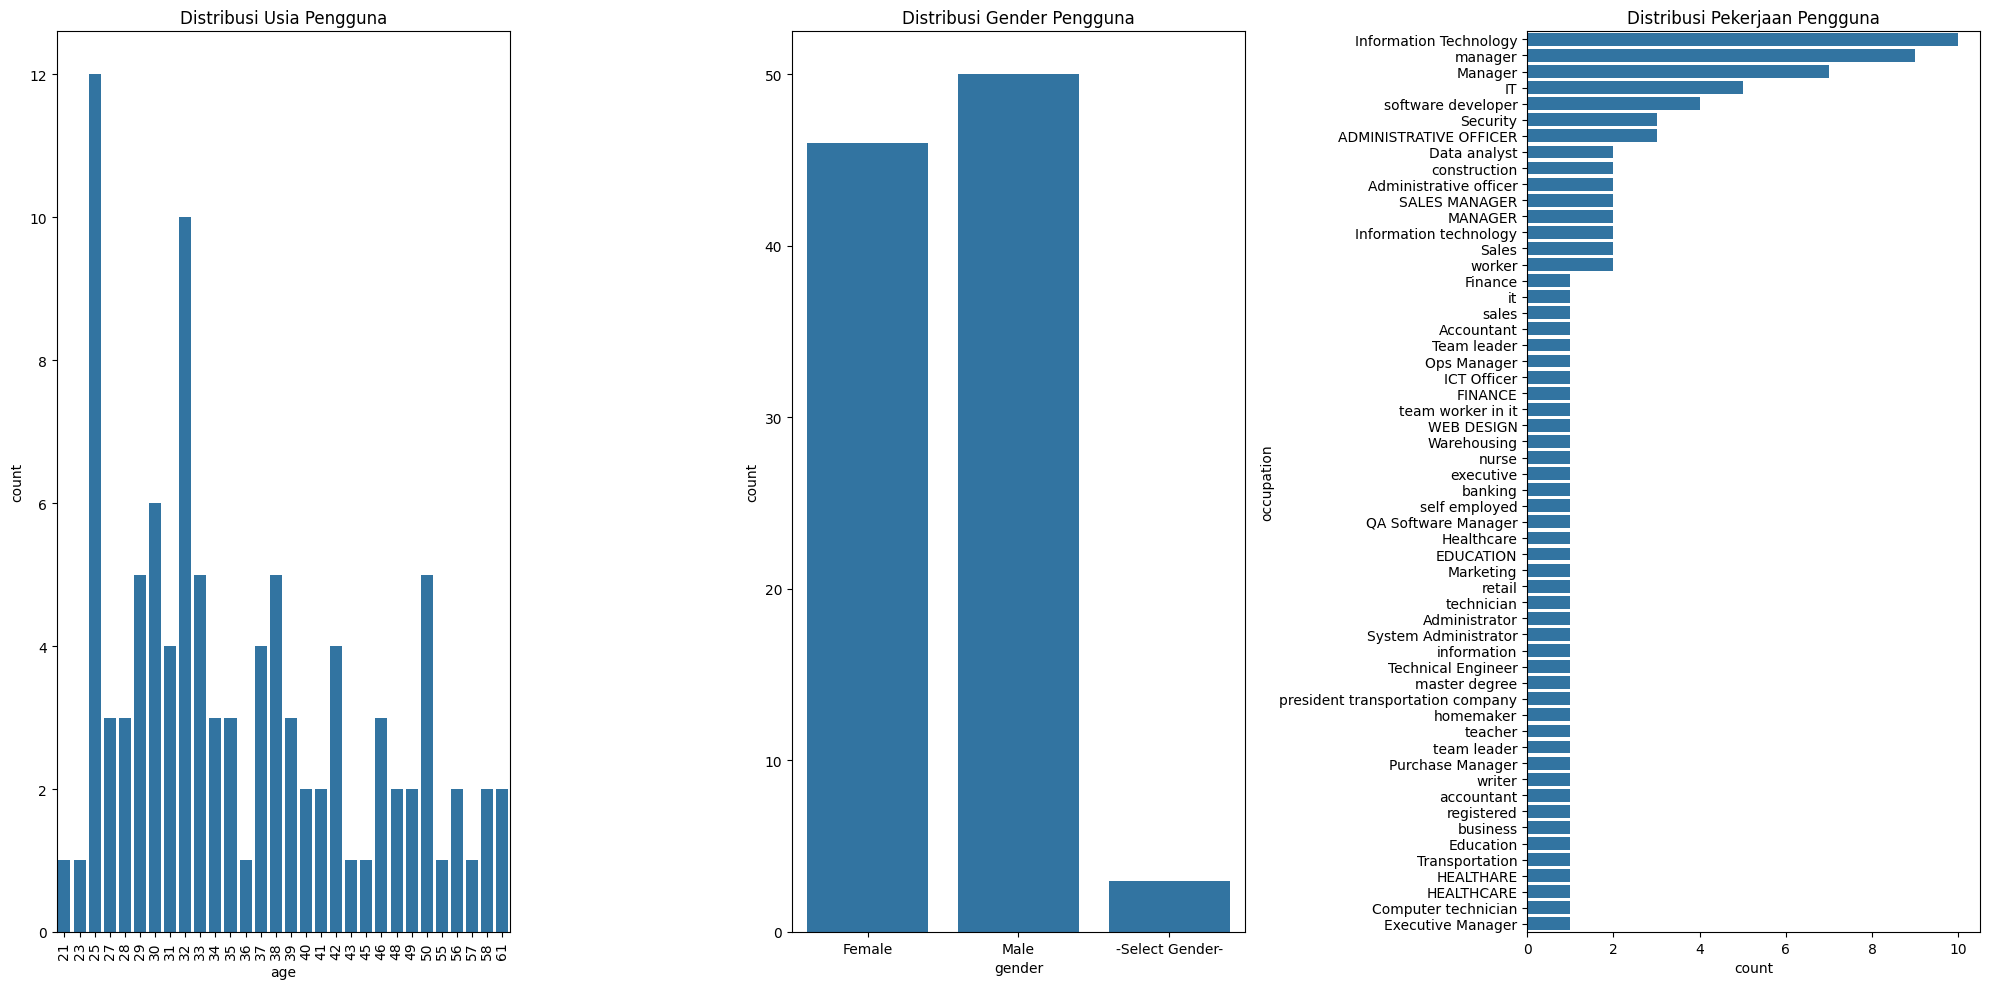

In [14]:
# Visualisasi karakteristik pengguna
plt.figure(figsize=(20, 10))

# Usia
plt.subplot(1, 3, 1)
sns.countplot(data=df_users, x='age')
plt.title('Distribusi Usia Pengguna')
plt.xticks(rotation=90)

# Gender
plt.subplot(1, 3, 2)
sns.countplot(data=df_users, x='gender')
plt.title('Distribusi Gender Pengguna')

# Pekerjaan
plt.subplot(1, 3, 3)
sns.countplot(data=df_users, y='occupation', order=df_users['occupation'].value_counts().index)
plt.title('Distribusi Pekerjaan Pengguna')

plt.tight_layout()
plt.show()

* **Distribusi Usia**

  * Rentang usia pengguna paling banyak berada di **21–31 tahun**, dengan puncaknya pada usia **25 tahun**.
  * Setelah usia 35 tahun, jumlah pengguna menurun secara signifikan.
  * Terdapat sebaran hingga usia 61 tahun, namun jumlahnya lebih kecil.

* **Distribusi Gender**

  * Komposisi gender cukup seimbang:

    * **Laki-laki** sedikit lebih banyak dari perempuan.
    * Ada sebagian kecil data dengan gender tidak terisi (`-Select Gender-`).

* **Distribusi Pekerjaan**

  * Pengguna terbanyak berasal dari bidang `IT` dan `teknologi informasi`:
  * Pekerjaan seperti `Information Technology`, `IT`, `software developer`, `Data analyst`, dan `System Administrator` mendominasi.
  * Beberapa pekerjaan di bidang manajerial juga muncul cukup sering: `Manager`, `SALES MANAGER`, `Administrative officer`.
  * Selain itu, ada keberagaman pekerjaan dari sektor **kesehatan, pendidikan, keuangan, retail, konstruksi**, hingga **homemaker**.
  * Pengguna berasal dari latar belakang pekerjaan yang beragam. Namun, terdapat beberapa **inkonsistensi** penulisan yang perlu dibersihkan, seperti:
    * Kesalahan penulisan seperti `healthare` yang seharusnya adalah `healthcare`.
    * Pekerjaan `information technology` dan `IT` dapat digabungkan karena merujuk pada bidang yang sama.

# Data Prepocessing

In [15]:
# Menggabungkan data rating dengan data ponsel
ratings_data = pd.merge(df_ratings, df_phones, how='inner', on='cellphone_id')
full_data = pd.merge(ratings_data, df_users, how='inner', on='user_id')

full_data.head()

,user_id,cellphone_id,rating,brand,model,operating system,internal memory,RAM,performance,main camera,selfie camera,battery size,screen size,weight,price,release date,release_year,age,gender,occupation
0,0,30,1,Motorola,Moto G Play (2021),Android,32,3,1.42,13,5,5000,6.5,204,159,2021-01-14,2021,38,Female,Data analyst
1,0,5,3,Apple,iPhone XR,iOS,64,3,4.22,12,7,2942,6.1,194,236,2018-10-26,2018,38,Female,Data analyst
2,0,10,9,Samsung,Galaxy S22,Android,128,8,8.81,50,10,3700,6.1,167,528,2022-02-25,2022,38,Female,Data analyst
3,0,9,3,Samsung,Galaxy A53,Android,128,6,3.79,64,32,5000,6.5,189,312,2022-03-24,2022,38,Female,Data analyst
4,0,23,2,Vivo,X80 Pro,Android,256,8,9.81,50,32,4700,6.7,215,872,2022-04-29,2022,38,Female,Data analyst


* Data rating digabung dengan data ponsel lewat `cellphone_id`, menghasilkan rating + detail ponsel.
* Lalu digabung dengan data user lewat `user_id`, membentuk data lengkap: rating + ponsel + user.

In [16]:
# Memeriksa nilai kosong pada data
full_data.isnull().sum()

,0
user_id,0
cellphone_id,0
rating,0
brand,0
model,0
operating system,0
internal memory,0
RAM,0
performance,0
main camera,0


* Semua kolom lengkap, kecuali `occupation` yang memiliki 10 data kosong.


In [17]:
# Menghapus baris dengan nilai kosong
full_data.dropna(inplace=True)
full_data.isnull().sum()

,0
user_id,0
cellphone_id,0
rating,0
brand,0
model,0
operating system,0
internal memory,0
RAM,0
performance,0
main camera,0


* Baris dengan nilai kosong telah dihapus.
* Semua kolom kini bersih dari missing value.

In [18]:
# Menyaring hanya rating dengan nilai 5 ke bawah
full_data = full_data[full_data['rating'] <= 5]

* Data difilter untuk menyisakan rating ≤ 5.


In [19]:
# Menstandarkan penulisan dan memperbaiki kesalahan pengetikan pada kolom occupation
full_data['occupation'] = full_data['occupation'].str.lower().replace({
    'healthare': 'healthcare',
    'it': 'information technology'
})

<ipython-input-19-cdcf5aa9e5eb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['occupation'] = full_data['occupation'].str.lower().replace({


* Penulisan pada kolom `occupation` diubah menjadi huruf kecil.
* Kesalahan ejaan seperti `healthare` diperbaiki menjadi `healthcare`.
* Istilah `it` diseragamkan menjadi `information technology`.


In [20]:
# Menyaring hanya nilai gender yang valid
valid_genders = ['Male', 'Female']
full_data = full_data[full_data['gender'].isin(valid_genders)]

* Data difilter untuk hanya menyertakan gender yang valid: `'Male'` dan `'Female'`.
* Baris dengan nilai gender di luar daftar tersebut dihapus dari dataset.


In [21]:
from datetime import datetime

# Menambahkan informasi waktu preprocessing
full_data['timestamp'] = datetime.now()

<ipython-input-21-083f675abbe1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_data['timestamp'] = datetime.now()


* Kolom `timestamp` ditambahkan untuk mencatat waktu preprocessing dilakukan.

In [22]:
# Menyalin data hasil preprocessing ke variabel baru
prepared_data = full_data.copy()
prepared_data

,user_id,cellphone_id,rating,brand,model,operating system,internal memory,RAM,performance,main camera,...,battery size,screen size,weight,price,release date,release_year,age,gender,occupation,timestamp
0,0,30,1,Motorola,Moto G Play (2021),Android,32,3,1.42,13,...,5000,6.5,204,159,2021-01-14,2021,38,Female,data analyst,2025-06-03 03:07:56.961106
1,0,5,3,Apple,iPhone XR,iOS,64,3,4.22,12,...,2942,6.1,194,236,2018-10-26,2018,38,Female,data analyst,2025-06-03 03:07:56.961106
3,0,9,3,Samsung,Galaxy A53,Android,128,6,3.79,64,...,5000,6.5,189,312,2022-03-24,2022,38,Female,data analyst,2025-06-03 03:07:56.961106
4,0,23,2,Vivo,X80 Pro,Android,256,8,9.81,50,...,4700,6.7,215,872,2022-04-29,2022,38,Female,data analyst,2025-06-03 03:07:56.961106
5,0,8,2,Samsung,Galaxy A32,Android,64,4,2.20,48,...,5000,6.5,205,199,2021-01-22,2021,38,Female,data analyst,2025-06-03 03:07:56.961106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,254,30,5,Motorola,Moto G Play (2021),Android,32,3,1.42,13,...,5000,6.5,204,159,2021-01-14,2021,25,Female,software developer,2025-06-03 03:07:56.961106
962,256,4,5,Apple,iPhone 13 Pro Max,iOS,256,6,8.01,12,...,4352,6.7,240,1199,2021-09-24,2021,49,Male,information technology,2025-06-03 03:07:56.961106
975,257,8,5,Samsung,Galaxy A32,Android,64,4,2.20,48,...,5000,6.5,205,199,2021-01-22,2021,25,Female,manager,2025-06-03 03:07:56.961106
977,257,30,5,Motorola,Moto G Play (2021),Android,32,3,1.42,13,...,5000,6.5,204,159,2021-01-14,2021,25,Female,manager,2025-06-03 03:07:56.961106


* Data hasil preprocessing disalin ke variabel baru `prepared_data` untuk keperluan selanjutnya.

# Data Preparation

In [23]:
# Menghapus duplikat berdasarkan cellphone_id
finalized_data = prepared_data.drop_duplicates(subset='cellphone_id')

* Duplikat berdasarkan `cellphone_id` dihapus untuk memastikan tiap ponsel hanya muncul sekali.


In [24]:
# Menggabungkan fitur teks penting untuk content-based filtering
finalized_data['combined_features'] = (
    finalized_data['brand'].astype(str) + " " +
    finalized_data['model'].astype(str) + " " +
    finalized_data['operating system'].astype(str)
)

<ipython-input-24-e7235e57db14>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finalized_data['combined_features'] = (


* Fitur teks `combined_features` dibuat dengan menggabungkan `brand`, `model`, dan `operating system` sebagai representasi konten untuk model content-based filtering.

In [25]:
# Menyimpan fitur yang dibutuhkan ke dalam df_content
df_content = finalized_data[['cellphone_id', 'brand', 'model', 'operating system', 'combined_features']].copy()
df_content

,cellphone_id,brand,model,operating system,combined_features
0,30,Motorola,Moto G Play (2021),Android,Motorola Moto G Play (2021) Android
1,5,Apple,iPhone XR,iOS,Apple iPhone XR iOS
3,9,Samsung,Galaxy A53,Android,Samsung Galaxy A53 Android
4,23,Vivo,X80 Pro,Android,Vivo X80 Pro Android
5,8,Samsung,Galaxy A32,Android,Samsung Galaxy A32 Android
6,22,Oppo,Find X5 Pro,Android,Oppo Find X5 Pro Android
7,16,Google,Pixel 6a,Android,Google Pixel 6a Android
8,19,OnePlus,Nord 2T,Android,OnePlus Nord 2T Android
12,18,OnePlus,Nord N20,Android,OnePlus Nord N20 Android
20,13,Samsung,Galaxy Z Flip 3,Android,Samsung Galaxy Z Flip 3 Android


* Data `df_content` berisi fitur penting: `cellphone_id`, `brand`, `model`, `operating system`, dan `combined_features`.
* Dataset ini disiapkan khusus untuk digunakan pada content-based filtering.


# Content Based Filtering

In [26]:
# TF-IDF dari combined_features
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df_content['combined_features'])

* Menggunakan **TF-IDF** untuk mengubah `combined_features` menjadi representasi numerik.

In [27]:
# Menghitung similarity antar model
similarity_matrix = cosine_similarity(tfidf_matrix)

* Menghitung **kemiripan antar model** dengan `cosine_similarity`.

In [28]:
# Membuat DataFrame similarity antar model
similarity_df = pd.DataFrame(
    similarity_matrix,
    index=df_content['model'],
    columns=df_content['model']
)

* Hasil similarity disimpan dalam `similarity_df`, berisi skor kesamaan antar model HP.

In [29]:
# Fungsi rekomendasi berdasarkan similarity konten
def recommend_similar_models(target_model, similarity_data=similarity_df, items=df_content[['model', 'brand', 'operating system']], top_n=4):
    """
    Rekomendasi model HP mirip berdasarkan kemiripan konten (brand, model, OS).
    """
    if target_model not in similarity_data.columns:
        raise ValueError(f"Model '{target_model}' tidak ditemukan dalam data.")

    # Urutkan skor similarity tertinggi, selain diri sendiri
    scores = similarity_data[target_model].sort_values(ascending=False)
    recommended = scores.drop(labels=[target_model]).head(top_n).index

    # Ambil info model yang direkomendasikan
    return items[items['model'].isin(recommended)].reset_index(drop=True)

* Fungsi `recommend_similar_models()` dibuat untuk:

  * Mencari model dengan fitur konten paling mirip (brand, model, OS).
  * Mengembalikan daftar model rekomendasi teratas berdasarkan kemiripan konten.

In [30]:
recommend_similar_models('iPhone 13')

,model,brand,operating system
0,iPhone XR,Apple,iOS
1,iPhone 13 Mini,Apple,iOS
2,iPhone 13 Pro Max,Apple,iOS
3,iPhone 13 Pro,Apple,iOS


**Rekomendasi untuk `iPhone 13`**

Model-model yang direkomendasikan semuanya berasal dari **brand dan sistem operasi yang sama (Apple, iOS)**, serta memiliki **kemiripan nama model**:

* **iPhone XR**, **iPhone 13 Mini**, **iPhone 13 Pro**, dan **iPhone 13 Pro Max** adalah bagian dari seri yang mirip, menandakan **konten fitur sangat serupa**.
* Ini menunjukkan bahwa pendekatan **content-based filtering** berhasil menangkap **kemiripan varian dalam satu lini produk**.

In [31]:
recommend_similar_models('Galaxy A53')

,model,brand,operating system
0,Galaxy A32,Samsung,Android
1,Galaxy Z Flip 3,Samsung,Android
2,Galaxy Z Fold 3,Samsung,Android
3,Galaxy S22,Samsung,Android


**Rekomendasi untuk `Galaxy A53`**

Model-model yang direkomendasikan berasal dari **brand Samsung** dan menggunakan **sistem operasi Android**:

* Disarankan model dari berbagai seri seperti **A-series (A32)** dan **Z-series (Z Flip 3, Z Fold 3)** serta **S-series (S22)**.
* Ini menunjukkan bahwa meskipun model berbeda, pendekatan konten menangkap **kemiripan brand dan OS**, serta mungkin kata "Galaxy" dalam nama model.

# Collaborative Filtering

In [32]:
# Salin data rating
df = df_ratings.copy()

In [33]:
# Encode user_id ke angka
user_ids = df['user_id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
df['user'] = df['user_id'].map(user_to_user_encoded)

# Encode cellphone_id ke angka
cellphone_ids = df['cellphone_id'].unique().tolist()
cellphone_to_cellphone_encoded = {x: i for i, x in enumerate(cellphone_ids)}
cellphone_encoded_to_cellphone = {i: x for i, x in enumerate(cellphone_ids)}
df['cellphone'] = df['cellphone_id'].map(cellphone_to_cellphone_encoded)

* **Encoding `user_id`**:

   * Membuat daftar unik `user_id`.
   * Menyusun mapping dari `user_id` asli ke angka urut (`user_to_user_encoded`).
   * Menyimpan mapping balik dari angka ke `user_id` asli (`user_encoded_to_user`).
   * Menambahkan kolom baru `user` berisi hasil encode.

* **Encoding `cellphone_id`**:

   * Hal serupa dilakukan untuk `cellphone_id`, menghasilkan kolom baru `cellphone`.


In [34]:
# Menghapus rating tidak valid & konversi tipe
df = df[df['rating'] != 18]
df['rating'] = df['rating'].astype(np.float32)

# Normalisasi rating
min_rating, max_rating = df['rating'].min(), df['rating'].max()
df['rating_norm'] = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))

# Mengacak urutan data
df = df.sample(frac=1, random_state=42)

<ipython-input-34-8d6457e571c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating'] = df['rating'].astype(np.float32)
<ipython-input-34-8d6457e571c4>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rating_norm'] = df['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating))




* Menghapus rating tidak valid (rating = 18).
* Mengonversi rating ke tipe `float32` untuk efisiensi memori.
* Menormalisasi rating ke rentang \[0, 1] agar model lebih stabil.
* Mengacak urutan data untuk menghindari bias saat pelatihan.

In [35]:
# Split data menjadi train dan validation
x = df[['user', 'cellphone']].values
y = df['rating_norm'].values
train_indices = int(0.8 * len(df))
x_train, x_val = x[:train_indices], x[train_indices:]
y_train, y_val = y[:train_indices], y[train_indices:]



* Membagi data menjadi **80% data latih** dan **20% data validasi**.
* Fitur input: pasangan `user` dan `cellphone`.
* Target output: `rating_norm` (rating yang telah dinormalisasi).


In [36]:
# Arsitektur Model RecommenderNet
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_cellphones, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.user_embedding = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-4)
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.cellphone_embedding = layers.Embedding(
            input_dim=num_cellphones,
            output_dim=embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-4)
        )
        self.cellphone_bias = layers.Embedding(num_cellphones, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        cellphone_vector = self.cellphone_embedding(inputs[:, 1])
        cellphone_bias = self.cellphone_bias(inputs[:, 1])
        dot_product = tf.reduce_sum(user_vector * cellphone_vector, axis=1, keepdims=True)
        x = dot_product + user_bias + cellphone_bias
        return tf.nn.sigmoid(x)

* Model **RecommenderNet** mempelajari representasi pengguna dan ponsel dengan *embedding*, lalu menghitung prediksi rating melalui *dot product* ditambah bias. Output dinormalisasi dengan sigmoid agar berada di rentang \[0, 1].


In [37]:
# Inisialisasi dan compile model
num_users = len(user_to_user_encoded)
num_cellphones = len(cellphone_to_cellphone_encoded)

model = RecommenderNet(num_users, num_cellphones, embedding_size=30)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)



* **Model diinisialisasi** dengan jumlah pengguna dan ponsel unik, menggunakan embedding size 30.
  Optimizer: **Adam**, Loss: **Binary Crossentropy**, Metrik: **RMSE**.


In [38]:
# Atur EarlyStopping
early_stop = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=10,
    restore_best_weights=True
)


* **EarlyStopping** digunakan untuk menghentikan pelatihan jika tidak ada peningkatan RMSE validasi selama 10 epoch.
  Parameter: `monitor='val_root_mean_squared_error'`, `patience=10`, `restore_best_weights=True`.


In [39]:
# Latih model
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=8,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.7048 - root_mean_squared_error: 0.3244 - val_loss: 0.7006 - val_root_mean_squared_error: 0.3089
Epoch 2/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6887 - root_mean_squared_error: 0.3236 - val_loss: 0.6943 - val_root_mean_squared_error: 0.3040
Epoch 3/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6760 - root_mean_squared_error: 0.3021 - val_loss: 0.6886 - val_root_mean_squared_error: 0.2993
Epoch 4/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6624 - root_mean_squared_error: 0.2822 - val_loss: 0.6834 - val_root_mean_squared_error: 0.2949
Epoch 5/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.6486 - root_mean_squared_error: 0.2741 - val_loss: 0.6789 - val_root_mean_squared_error: 0.2910
Epoch 6/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.6326 - root_mean_squared_error: 0.2718 - val_loss: 0.6747 - val_root_mean_squared_error: 0.2872
Epoch 7/100
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - lo


* **Model dilatih** hingga 100 epoch dengan batch size 8, menggunakan data validasi dan callback EarlyStopping.


# Evaluation

In [40]:
# Evaluasi data training
y_train_pred = model.predict(x_train).flatten()
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Evaluasi data validasi
y_val_pred = model.predict(x_val).flatten()
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"RMSE Train     : {rmse_train:.4f}")
print(f"RMSE Validation: {rmse_val:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
RMSE Train     : 0.0262
RMSE Validation: 0.2331


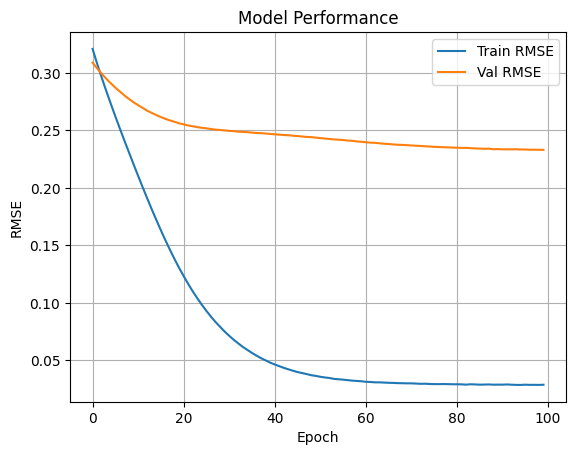

In [41]:
# Visualisasi RMSE
plt.plot(history.history['root_mean_squared_error'], label='Train RMSE')
plt.plot(history.history['val_root_mean_squared_error'], label='Val RMSE')
plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
# Load ulang rating dan salin data ponsel
df_rating = pd.read_csv('cellphones ratings.csv')
phone_df = df_phones.copy()

In [43]:
def recommend_for_user(user_id, top_n=10):
    # Mengecek apakah user ID valid
    if user_id not in user_to_user_encoded:
        print("User ID tidak ditemukan dalam data.")
        return

    # Mengambil ponsel yang sudah direview oleh user
    cellphone_reviewed_by_user = df_rating[df_rating['user_id'] == user_id]

    # Memfilter ponsel yang belum direview
    cellphone_not_reviewed = phone_df[~phone_df['cellphone_id'].isin(cellphone_reviewed_by_user['cellphone_id'].values)]
    cellphone_not_reviewed = cellphone_not_reviewed[cellphone_not_reviewed['cellphone_id'].isin(cellphone_to_cellphone_encoded)]

    # Encode user dan ponsel untuk input ke model
    cellphone_not_reviewed_encoded = [[cellphone_to_cellphone_encoded.get(x)] for x in cellphone_not_reviewed['cellphone_id']]
    user_encoded = user_to_user_encoded.get(user_id)
    user_cellphone_array = np.hstack(([[user_encoded]] * len(cellphone_not_reviewed_encoded), cellphone_not_reviewed_encoded))

    # Memprediksi rating ponsel yang belum direview
    ratings = model.predict(user_cellphone_array).flatten()
    predicted_ratings = ratings * (max_rating - min_rating) + min_rating  # Konversi dari sigmoid ke skala rating asli

    # Mengambil indeks ponsel dengan prediksi tertinggi
    top_ratings_indices = predicted_ratings.argsort()[-top_n:][::-1]
    recommended_cellphone_ids = [cellphone_encoded_to_cellphone.get(cellphone_not_reviewed_encoded[x][0]) for x in top_ratings_indices]

    # Menampilkan ponsel yang paling disukai user
    print(f"\nRekomendasi untuk pengguna: {user_id}")
    print("=" * 40)
    print("Ponsel dengan rating tertinggi oleh pengguna ini:")
    print("-" * 40)
    top_cellphones = (
        cellphone_reviewed_by_user.sort_values(by='rating', ascending=False)
        .head(5)['cellphone_id'].values
    )
    top_reviewed = phone_df[phone_df['cellphone_id'].isin(top_cellphones)]
    for row in top_reviewed.itertuples():
        print(f"{row.brand} : {row.model}")

    # Menampilkan rekomendasi ponsel
    print("-" * 40)
    print(f"Top {top_n} Rekomendasi Ponsel:")
    print("-" * 40)
    recommended_phones = phone_df[phone_df['cellphone_id'].isin(recommended_cellphone_ids)]
    for row in recommended_phones.itertuples():
        print(f"{row.brand} : {row.model}")


In [44]:
recommend_for_user(user_id=1, top_n=10)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

Rekomendasi untuk pengguna: 1
Ponsel dengan rating tertinggi oleh pengguna ini:
----------------------------------------
Apple : iPhone 13 Pro
Samsung : Galaxy A13
Samsung : Galaxy A32
Google : Pixel 6  
Sony : Xperia Pro
----------------------------------------
Top 10 Rekomendasi Ponsel:
----------------------------------------
Apple : iPhone SE (2022)
Apple : iPhone 13 Mini
Apple : iPhone 13
Apple : iPhone XR
Samsung : Galaxy S22
Samsung : Galaxy S22 Ultra
Google : Pixel 6 Pro 
OnePlus : 10 Pro
Oppo : Find X5 Pro
Vivo : X80 Pro
